<a href="https://colab.research.google.com/github/catastropiyush/arxiv.py/blob/master/Copy_of_arxiv_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArXiv API

The ArXiV API allows programmatic access to the arXiv's e-print content and metadata. "The goal of the interface is to facilitate new and creative use of the the vast body of material on the arXiv by providing a low barrier to entry for application developers." https://arxiv.org/help/api

The API's user manual (https://arxiv.org/help/api/user-manual) provides helpful documentation for using the API and retrieving article metadata.

Our examples below will introduce you to the basics of querying the ArXiV API.

## Install Packages

In [2]:
!pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=4bf6f8a1720a312d0b81d3947035a0ba1306cc613e8c0de8efe5b2084f9f4ee0
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [3]:
import urllib
import arxiv
import requests
import json
import csv
import pandas as pd
from collections import Counter, defaultdict
import numpy as np # for array manipulation
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
import datetime

## Query the API

Perform a simple query for "graphene." We'll limit results to the titles of the 10 most recent papers.

In [8]:
search = arxiv.Search(
  query = "MOF",
  max_results = 15,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

for result in search.results():
  print(result.title)

<ipython-input-8-2f82206d9ec7>:7: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Towards LLMs Robustness to Changes in Prompt Format Styles
Cluster-based machine learning potentials to describe disordered metal-organic frameworks up to the mesoscale
The structure and topology of an amorphous metal-organic framework
DeepAudio-V1:Towards Multi-Modal Multi-Stage End-to-End Video to Speech and Audio Generation
Piezoelectric Transition in a Nonpyroelectric Gyroidal Metal-Organic Framework
Mechano-Bactericidal Surfaces Achieved by Epitaxial Growth of Metal-Organic Frameworks
TBHubbard: tight-binding and extended Hubbard model database for metal-organic frameworks
Benchmarking Selected Density Functionals and Dispersion Corrections for MOF-5 and its Derivatives
Tuning Magnetism of Metal-Organic Framework by Different Types of Pressure
Amorphous to Crystalline Transformation: How Cluster Aggregation Drives the Multistep Nucleation of ZIF-8
Ferroelectric Chirality-Driven Direction-Tunable and Spin-Invertible Corner States in 2D MOF-Based Magnetic Second-Order Topological In

Do another query for the topic "quantum dots," but note that you could swap in a topic of your liking.

You can define a custom arXiv API client with specialized pagination behavior. This time we'll process each paper as it's fetched rather than exhausting the result-generator into a `list`; this is useful for running analysis while the client sleeps.

Because this `arxiv.Search` doesn't bound the number of results with `max_results`, it will fetch *every* matching paper (roughly 10,000). This may take several minutes.

In [9]:
results_generator = arxiv.Client(
  page_size=1000,
  delay_seconds=3,
  num_retries=3
).results(arxiv.Search(
  query='"MOF"',
  id_list=[],
  sort_by=arxiv.SortCriterion.Relevance,
  sort_order=arxiv.SortOrder.Descending,
))

quantum_dots = []
for paper in results_generator:
  # You could do per-paper analysis here; for now, just collect them in a list.
  quantum_dots.append(paper)

## Organize and analyze your results

Create a dataframe to better analyze your results. This example uses Python's [`vars`](https://docs.python.org/3/library/functions.html#vars) built-in function to convert search results into Python dictionaries of paper metadata.

In [10]:
qd_df = pd.DataFrame([vars(paper) for paper in quantum_dots])

We'll look at the first 10 results.

In [11]:
qd_df.head(10)

,entry_id,updated,published,title,authors,summary,comment,journal_ref,doi,primary_category,categories,links,pdf_url,_raw
0,http://arxiv.org/abs/2207.04502v2,2023-11-29 17:20:33+00:00,2022-07-10 16:41:11+00:00,Building Open Knowledge Graph for Metal-Organi...,"[Yuan An, Jane Greenberg, Xintong Zhao, Xiaohu...",Metal-Organic Frameworks (MOFs) are a class of...,Accepted by the International Workshop on Know...,None,None,cs.AI,[cs.AI],"[http://arxiv.org/abs/2207.04502v2, http://arx...",http://arxiv.org/pdf/2207.04502v2,"{'id': 'http://arxiv.org/abs/2207.04502v2', 'g..."
1,http://arxiv.org/abs/2310.00823v1,2023-10-01 23:47:13+00:00,2023-10-01 23:47:13+00:00,Unveiling the Regulatory Factors for Phase Tra...,"[Zuhao Shi, Bin Liu, Yuanzheng Yue, Arramel Ar...","Recently, there have been significant advancem...","22 pages, 4 figures",None,None,cond-mat.mtrl-sci,[cond-mat.mtrl-sci],"[http://arxiv.org/abs/2310.00823v1, http://arx...",http://arxiv.org/pdf/2310.00823v1,"{'id': 'http://arxiv.org/abs/2310.00823v1', 'g..."
2,http://arxiv.org/abs/2407.00470v1,2024-06-29 15:32:44+00:00,2024-06-29 15:32:44+00:00,Unusual Pore Volume Dependence of Water Sorpti...,"[Jiawang Li, Guang Wang, Hongzhao Fan, Zhigang...","Monolithic metal-organic frameworks (MOFs), wh...",None,None,None,physics.app-ph,"[physics.app-ph, cond-mat.mtrl-sci]","[http://arxiv.org/abs/2407.00470v1, http://arx...",http://arxiv.org/pdf/2407.00470v1,"{'id': 'http://arxiv.org/abs/2407.00470v1', 'g..."
3,http://arxiv.org/abs/1604.00337v1,2016-04-01 17:43:11+00:00,2016-04-01 17:43:11+00:00,Understanding and Controlling Water Stability ...,"[S. Zuluaga, E. M. A. Fuentes-Fernandez, K. Ta...",Metal organic framework (MOF) materials in gen...,None,"Journal of Materials Chemistry A, 2016, 4, 517...",10.1039/C5TA10416E,cond-mat.mtrl-sci,[cond-mat.mtrl-sci],"[http://dx.doi.org/10.1039/C5TA10416E, http://...",http://arxiv.org/pdf/1604.00337v1,"{'id': 'http://arxiv.org/abs/1604.00337v1', 'g..."
4,http://arxiv.org/abs/2108.13590v1,2021-08-31 02:37:30+00:00,2021-08-31 02:37:30+00:00,Mining Insights on Metal-Organic Framework Syn...,"[Hyunsoo Park, Yeonghun Kang, Wonyoung Choe, J...",Identifying optimal synthesis conditions for m...,None,None,None,cond-mat.mtrl-sci,"[cond-mat.mtrl-sci, physics.chem-ph]","[http://arxiv.org/abs/2108.13590v1, http://arx...",http://arxiv.org/pdf/2108.13590v1,"{'id': 'http://arxiv.org/abs/2108.13590v1', 'g..."
5,http://arxiv.org/abs/2206.13473v1,2022-06-27 17:26:54+00:00,2022-06-27 17:26:54+00:00,Metal-Organic Frameworks in Semiconductor Devi...,"[Ranjeev Kumar Parashar, Priyajit Jash, Prakas...",Metal-organic frameworks (MOFs) symbolize the ...,None,None,None,cond-mat.mtrl-sci,[cond-mat.mtrl-sci],"[http://arxiv.org/abs/2206.13473v1, http://arx...",http://arxiv.org/pdf/2206.13473v1,"{'id': 'http://arxiv.org/abs/2206.13473v1', 'g..."
6,http://arxiv.org/abs/2210.03219v1,2022-10-06 21:25:52+00:00,2022-10-06 21:25:52+00:00,Fracture behavior of MOF monoliths revealed by...,"[Michele Tricarico, Jin-Chong Tan]",Monolithic metal-organic frameworks (MOFs) rep...,"15 pages, 5 figures, Supporting Information",None,None,cond-mat.mtrl-sci,[cond-mat.mtrl-sci],"[http://arxiv.org/abs/2210.03219v1, http://arx...",http://arxiv.org/pdf/2210.03219v1,"{'id': 'http://arxiv.org/abs/2210.03219v1', 'g..."
7,http://arxiv.org/abs/2210.14191v1,2022-10-25 17:38:42+00:00,2022-10-25 17:38:42+00:00,A Database of Ultrastable MOFs Reassembled fro...,"[Aditya Nandy, Shuwen Yue, Changhwan Oh, Chenr...",High-throughput screening of large hypothetica...,None,None,None,cond-mat.mtrl-sci,"[cond-mat.mtrl-sci, cs.LG, physics.chem-ph]","[http://arxiv.org/abs/2210.14191v1, http://arx...",http://arxiv.org/pdf/2210.14191v1,"{'id': 'http://arxiv.org/abs/2210.14191v1', 'g..."
8,http://arxiv.org/abs/2401.08148v1,2024-01-16 06:42:13+00:00,2024-01-16 06:42:13+00:00,Metal-organic Frameworks in Semiconductor Devi...,"[Ranjeev Kumar Parashar, Priyajit Jash, Michae...",Metal-organic frameworks (MOFs) are a specific...,"3

Next, we'll create list of all of the columns in the dataframe to see what else is there:

In [12]:
list(qd_df)

['entry_id',
 'updated',
 'published',
 'title',
 'authors',
 'summary',
 'comment',
 'journal_ref',
 'doi',
 'primary_category',
 'categories',
 'links',
 'pdf_url',
 '_raw']

We have 14 columns overall. We'll add two derived columns––the name of the first listed author and a reference to the original `arxiv.Result` object-–then narrow the dataframe to paper titles, `published` dates, and first authors to run some analysis of publishing patterns over time.

In [13]:
# Add a first_author column: the name of the first author among each paper's list of authors.
qd_df['first_author'] = [authors_list[0].name for authors_list in qd_df['authors']]
# Keep a reference to the original results in the dataframe: this is useful for downloading PDFs.
qd_df['_result'] = quantum_dots

# Narrow our dataframe to just the columns we want for our analysis.
qd_df = qd_df[['title', 'published', 'first_author', '_result']]
qd_df

,title,published,first_author,_result
0,Building Open Knowledge Graph for Metal-Organi...,2022-07-10 16:41:11+00:00,Yuan An,http://arxiv.org/abs/2207.04502v2
1,Unveiling the Regulatory Factors for Phase Tra...,2023-10-01 23:47:13+00:00,Zuhao Shi,http://arxiv.org/abs/2310.00823v1
2,Unusual Pore Volume Dependence of Water Sorpti...,2024-06-29 15:32:44+00:00,Jiawang Li,http://arxiv.org/abs/2407.00470v1
3,Understanding and Controlling Water Stability ...,2016-04-01 17:43:11+00:00,S. Zuluaga,http://arxiv.org/abs/1604.00337v1
4,Mining Insights on Metal-Organic Framework Syn...,2021-08-31 02:37:30+00:00,Hyunsoo Park,http://arxiv.org/abs/2108.13590v1
...,...,...,...,...
338,Computer Simulation of the Early Stages of Sel...,2022-06-29 16:54:43+00:00,Salvador R. G. Balestra,http://arxiv.org/abs/2206.14765v3
339,Mutually orthogonal frequency rectangles,2022-12-21 00:53:29+00:00,Fahim Rahim,http://arxiv.org/abs/2212.10706v1
340,PolySilicate Porous Organic Polymers (PSiPOPs)...,2024-01-22 12:40:28+00:00,Jelle Jamoul,http://arxiv.org/abs/2401.11893v1
341,Coarse grained modeling of a metal-organic fra...,2024-10-08 14:06:34+00:00,Cecilia M. S. Alvares,http://arxiv.org/abs/2410.14708v1


## Visualize your results

Get a sense of the how your topic has trended over time. When did research on your topic take off? Create a bar chart of the number of articles published in each year.

<Axes: xlabel='published'>

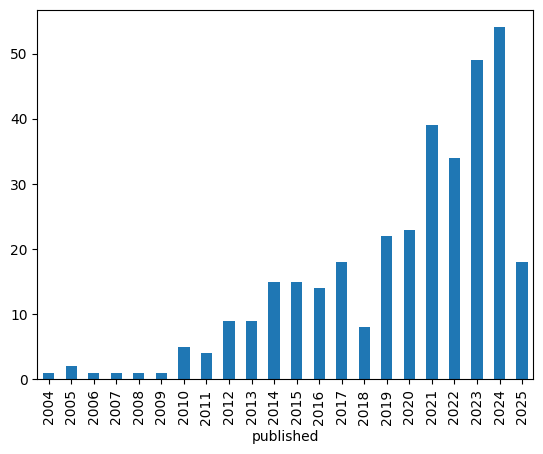

In [14]:
qd_df["published"].groupby(qd_df["published"].dt.year).count().plot(kind="bar")

Explore authors to see who is publishing your topic. Group by author, then sort and select the top 20 authors.

In [15]:
qd_authors = qd_df.groupby(qd_df["first_author"])["first_author"].count().sort_values(ascending=False)
qd_authors.head(20)

,first_author
first_author,
Pieremanuele Canepa,4
Kui Tan,4
Arun S. Babal,3
Cecilia M. S. Alvares,3
Abhijeet K. Chaudhari,3
Mario Gutiérrez,3
S. Zuluaga,3
Zhiling Zheng,3
Zhouteng Ye,2


## Identify and download papers

Let's download the oldest paper about quantum dots co-authored by Piotr Trocha:

In [16]:
qd_Trocha_sorted  = qd_df[qd_df['first_author']=='Kui Tan'].sort_values('published')
qd_Trocha_sorted

,title,published,first_author,_result
231,Stability and Hydrolyzation of Metal Organic F...,2012-09-12 11:21:01+00:00,Kui Tan,http://arxiv.org/abs/1209.2564v1
334,Mechanism of preferential adsorption of SO$_2$...,2013-10-26 10:33:22+00:00,Kui Tan,http://arxiv.org/abs/1310.7094v1
86,Water Reaction Mechanism in Metal Organic Fram...,2014-11-21 01:16:36+00:00,Kui Tan,http://arxiv.org/abs/1411.5736v1
220,"Competitive co-adsorption of CO2 with H2O, NH3...",2015-03-16 16:42:12+00:00,Kui Tan,http://arxiv.org/abs/1503.04721v1


In [17]:
# Use the arxiv.Result object stored in the _result column to trigger a PDF download.
qd_Trocha_oldest = qd_Trocha_sorted.iloc[0]
qd_Trocha_oldest._result.download_pdf()

'./1209.2564v1.Stability_and_Hydrolyzation_of_Metal_Organic_Frameworks_with_Paddle_Wheel_SBUs_upon_Hydration.pdf'

Confirm that the PDF has downloaded!

## Bibliography

- Tim Head: https://betatim.github.io/posts/analysing-the-arxiv/
- Lukas Schwab: https://github.com/lukasschwab/arxiv.py
- ArXiV API user manual: https://arxiv.org/help/api/user-manual        